In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


import matplotlib.pyplot as plt


# Set random seed
seed = 0



In [2]:
# Read cleaned data from csv
df = pd.read_csv('input/movie_data_tmbd_cleaned.csv', sep='|')

In [3]:
# Print info about the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 8784 non-null   int64  
 1   budget                8784 non-null   int64  
 2   genres                8780 non-null   object 
 3   original_language     8784 non-null   object 
 4   overview              8763 non-null   object 
 5   popularity            8784 non-null   float64
 6   production_companies  8618 non-null   object 
 7   production_countries  8737 non-null   object 
 8   revenue               8784 non-null   int64  
 9   runtime               8784 non-null   float64
 10  spoken_languages      8768 non-null   object 
 11  status                8784 non-null   object 
 12  tagline               6912 non-null   object 
 13  title                 8784 non-null   object 
 14  video                 8784 non-null   int64  
 15  vote_average         

# Scoring prediction

In [4]:
df['video'].value_counts()

video
0    8778
1       6
Name: count, dtype: int64

In [5]:
# Get list of all unique names in df[`cast`]
df['cast'] = df['cast'].replace(np.nan, '')
unique_cast = df['cast'].str.split(',').explode()
unique_cast.value_counts()
# Take only actors that appeared in more than 10 movies
top_cast = unique_cast.value_counts()[unique_cast.value_counts() > 10]

df['cast'] = df['cast'].apply(lambda x: [i for i in x.split(',') if i in top_cast.index]).apply(lambda x: ','.join(x))
df['production_companies'] = df['production_companies'].replace(np.nan, '')
unique_production_companies = df['production_companies'].str.split(',').explode()
unique_production_companies.value_counts()

top_companies = unique_production_companies.value_counts()[unique_production_companies.value_counts() > 10]
df['production_companies'] = df['production_companies'].apply(lambda x: [i for i in x.split(',') if i in top_companies.index]).apply(lambda x: ','.join(x))
df['directors'] = df['directors'].replace(np.nan, '')
unique_directors = df['directors'].str.split(',').explode()
unique_directors.value_counts()

top_directors = unique_directors.value_counts()[unique_directors.value_counts() > 10]
df['directors'] = df['directors'].apply(lambda x: [i for i in x.split(',') if i in top_directors.index]).apply(lambda x: ','.join(x))
df['production_countries'] = df['production_countries'].replace(np.nan, '')
df['spoken_languages'] = df['spoken_languages'].replace(np.nan, '')
df['genres'] = df['genres'].replace(np.nan, '')
df['tagline'] = df['tagline'].replace(np.nan, '')
df['overview'] = df['overview'].replace(np.nan, '')

In [6]:
X = df.drop(columns=['vote_average', 'category'])
X = df.drop(columns=['video', 'adult', 'release_day'])
Y = df['category']


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Encode target variable (Y) using LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  7027
Test set size:  1757


# Feature encoding

In [8]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                8784 non-null   int64  
 1   genres                8784 non-null   object 
 2   original_language     8784 non-null   object 
 3   overview              8784 non-null   object 
 4   popularity            8784 non-null   float64
 5   production_companies  8784 non-null   object 
 6   production_countries  8784 non-null   object 
 7   revenue               8784 non-null   int64  
 8   runtime               8784 non-null   float64
 9   spoken_languages      8784 non-null   object 
 10  status                8784 non-null   object 
 11  tagline               8784 non-null   object 
 12  title                 8784 non-null   object 
 13  vote_average          8784 non-null   float64
 14  vote_count            8784 non-null   float64
 15  cast                 

In [9]:
print(X.head())

      budget                                         genres original_language  \
0  200000000      Adventure,Action,Thriller,Science Fiction                en   
1  130000000               Science Fiction,Action,Adventure                en   
2  165000000               Action,Adventure,Science Fiction                en   
3  120000000               Action,Adventure,Science Fiction                en   
4   78000000  Fantasy,Action,Crime,Science Fiction,Thriller                en   

                                            overview  popularity  \
0  For centuries, a small but powerful force of w...      31.264   
1  One thousand years after cataclysmic events fo...      29.537   
2  We always knew they were coming back. Using re...      33.521   
3  Four young outsiders teleport to a dangerous u...      24.238   
4  He dwells in a world of eternal night, but the...      23.563   

                                production_companies  \
0  DC Entertainment,De Line Pictures,Warner Bros

In [10]:

numerical_features = ['budget', 'revenue', 'popularity', 'runtime', 'vote_count', 'release_year', 'release_month']
categorical_features = ['original_language', 'status']
boolean_features = ['adult', 'video']
text_features = ['overview', 'tagline', 'title']
list_based_features = ['genres', 'production_companies', 'production_countries', 'cast', 'directors']

# 1. Numerical transformer: Impute missing values and standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical transformer: Impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# 3. Boolean transformer: Ensure 0/1 values
boolean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# 4. Text transformer: Use TF-IDF for text columns
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=100))  # Adjust max_features as needed
])

# 5. List-based transformer: Convert list of items into count vectors (like multi-hot encoding)
def list_to_str(column):
    return column.apply(lambda x: ','.join(x) if isinstance(x, list) else '')

# Combine all transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        # ('bool', boolean_transformer, boolean_features),
        ('overview', text_transformer, 'overview'),
        ('tagline', text_transformer, 'tagline'),
        ('genres', text_transformer, 'genres'),
        ('production_companies', text_transformer, 'production_companies'),
        ('production_countries', text_transformer, 'production_countries'),
        ('cast', text_transformer, 'cast'),
        ('directors', text_transformer, 'directors')
    ]
)

In [11]:
X_train_encoded = preprocessor.fit_transform(X_train)
print(X_train_encoded)

X_test_encoded = preprocessor.transform(X_test)  #Just transform, not fit so they have the same number of features
print(X_test_encoded)

  (0, 0)	-0.08619960335899651
  (0, 1)	-0.18237344551555748
  (0, 2)	0.08345800497584235
  (0, 3)	-0.5505827317471977
  (0, 4)	1.795802171379134
  (0, 5)	0.42331317103209676
  (0, 6)	1.2175666622553376
  (0, 15)	1.0
  (0, 42)	1.0
  (0, 116)	0.5864674656785438
  (0, 124)	0.5226236148284815
  (0, 130)	0.6188056794537337
  (0, 199)	1.0
  (0, 244)	0.6937175157199655
  (0, 249)	0.46303948736614914
  (0, 260)	0.5516796548025068
  (0, 273)	0.28120239791970725
  (0, 299)	0.43938915948487495
  (0, 302)	0.29381623162362774
  (0, 329)	0.440833707193948
  (0, 331)	0.33524861148923174
  (0, 333)	0.2608753051066312
  (0, 343)	0.4338761288913083
  (0, 360)	0.28018563672299496
  (0, 367)	0.302264718805644
  :	:
  (7025, 452)	0.2912134271980113
  (7025, 461)	0.27482428700138295
  (7026, 0)	0.1793668052887353
  (7026, 1)	-0.1509840149906671
  (7026, 2)	-0.12953782644463857
  (7026, 3)	-1.1135691250570259
  (7026, 4)	-0.07500471776376888
  (7026, 5)	0.4843423180098479
  (7026, 6)	0.34449197240177887
  (7

In [13]:
print(f"X_train_encoded shape: {X_train_encoded.shape}")
print(f"X_test_encoded shape: {X_test_encoded.shape}")


X_train_encoded shape: (7027, 664)
X_test_encoded shape: (1757, 664)


# Opaque Models

## Random Forest

In [14]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=seed)

rf_model.fit(X_train_encoded, Y_train_encoded)

RandomForestClassifier(random_state=0)

In [15]:
Y_pred = rf_model.predict(X_test_encoded)

In [16]:
accuracy = accuracy_score(Y_test_encoded, Y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6887


In [17]:
print(classification_report(Y_test_encoded, Y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         bad       0.90      0.79      0.84       450
        good       0.54      0.64      0.59       430
       great       0.74      0.67      0.71       429
    mediocre       0.62      0.65      0.63       448

    accuracy                           0.69      1757
   macro avg       0.70      0.69      0.69      1757
weighted avg       0.70      0.69      0.69      1757



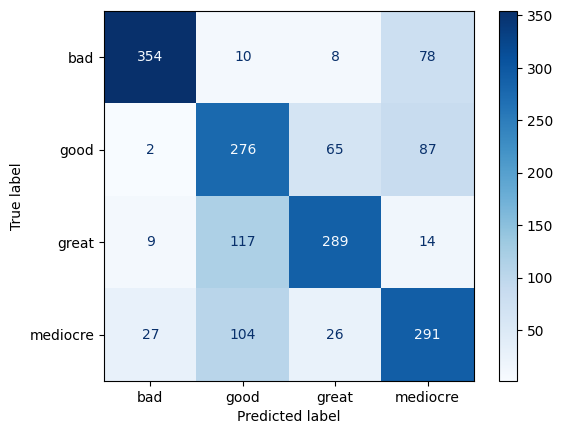

In [18]:
cm = confusion_matrix(Y_test_encoded, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [42]:
# Get feature names for numerical columns (unchanged)
numeric_feature_names = numerical_features

# Get feature names for categorical columns (OneHotEncoder expands them)
cat_encoder = preprocessor.named_transformers_['cat'][1]  # OneHotEncoder
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

# Generate feature names for text and list-based columns (TfidfVectorizer)
text_and_list_feature_names = []
for text_col in ['overview', 'tagline', 'genres', 'production_companies', 'production_countries', 'cast', 'directors']:
    vectorizer = preprocessor.named_transformers_[text_col]['tfidf']  # Access the TfidfVectorizer
    feature_names = vectorizer.get_feature_names_out()  # Get the names of the 100 features
    # Add the column name as a prefix to each feature name to distinguish them
    text_and_list_feature_names.extend([f"{text_col}_{name}" for name in feature_names])

# Combine all feature names
all_feature_names = numeric_feature_names + list(cat_feature_names) + text_and_list_feature_names

# Ensure that all_feature_names length matches feature_importances length
print(f"Length of feature names: {len(all_feature_names)}")
print(f"Length of feature importances: {len(rf_model.feature_importances_)}")

# Create DataFrame for feature importances
feature_importances_df = pd.DataFrame({'feature': all_feature_names, 'importance': rf_model.feature_importances_})

# Sort the DataFrame by feature importance
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the result
print(feature_importances_df)


Length of feature names: 664
Length of feature importances: 664
                          feature  importance
4                      vote_count    0.124209
2                      popularity    0.051983
3                         runtime    0.044159
5                    release_year    0.042518
1                         revenue    0.038316
..                            ...         ...
42                status_Released    0.000000
388   production_countries_cyprus    0.000000
430  production_countries_namibia    0.000000
8            original_language_bn    0.000000
32           original_language_ro    0.000000

[664 rows x 2 columns]


In [43]:
# Print 50 most important features
print(feature_importances_df.head(50))

                                feature  importance
4                            vote_count    0.124209
2                            popularity    0.051983
3                               runtime    0.044159
5                          release_year    0.042518
1                               revenue    0.038316
0                                budget    0.027353
249                        genres_drama    0.022815
254                       genres_horror    0.015624
6                         release_month    0.014091
246                       genres_comedy    0.012625
461         production_countries_united    0.011154
452         production_countries_states    0.010071
331       production_companies_pictures    0.009771
260                     genres_thriller    0.008454
243                       genres_action    0.008077
15                 original_language_en    0.008048
367        production_countries_america    0.007877
248                  genres_documentary    0.007785
252         

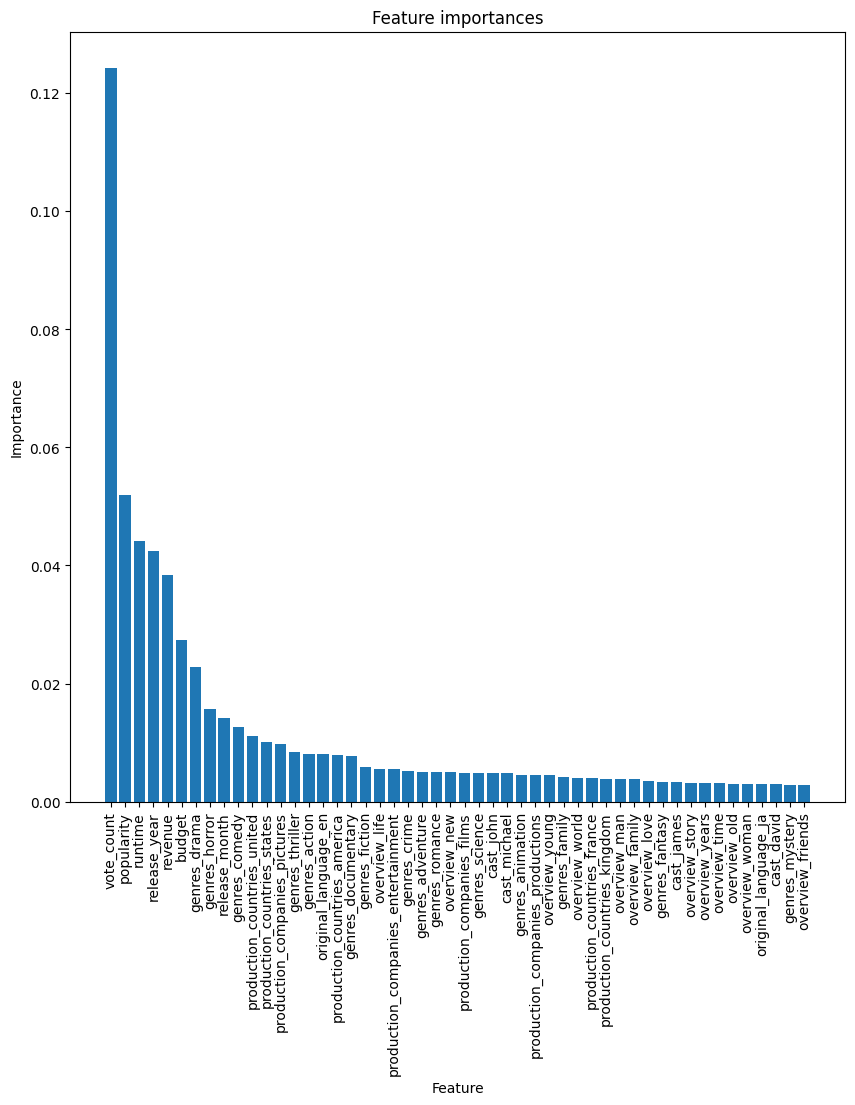

In [40]:
# plot as bars first 50 feature importances, with no labels
plt.figure(figsize=(10, 10))
plt.bar(range(50), feature_importances_df['importance'][:50], align='center')
plt.xticks(range(50), feature_importances_df['feature'][:50], rotation=90)
plt.title('Feature importances')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

#### Wrapper to tune parameters - GridSearch

In [62]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],            #Number of trees    
    'max_features': ['auto', 'sqrt', 'log2'],          
    'max_depth': [10, 20, 50, None],                   
    'min_samples_split': [2, 5, 10],                    
    'min_samples_leaf': [1, 2, 4],                     
    'bootstrap': [True, False]                         
}

In [63]:
grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    scoring='accuracy', 
    cv=5, 
    verbose=2, 
    n_jobs=-1
)

In [65]:
grid_search.fit(X_train_encoded, Y_train_encoded)

print("Melhores parâmetros:", grid_search.best_params_)
#~85 min
#Fitting 5 folds for each of 864 candidates, totalling 4320 fits
#ythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
#Melhores parâmetros: {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1440 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1210 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Azevedo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCach

Melhores parâmetros: {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


In [66]:
best_rf_model = grid_search.best_estimator_
Y_pred = best_rf_model.predict(X_test_encoded)

In [67]:
accuracy = accuracy_score(Y_test_encoded, Y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6932


In [68]:
print(classification_report(Y_test_encoded, Y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         bad       0.94      0.79      0.86       450
        good       0.55      0.61      0.58       430
       great       0.74      0.69      0.71       429
    mediocre       0.61      0.69      0.65       448

    accuracy                           0.69      1757
   macro avg       0.71      0.69      0.70      1757
weighted avg       0.71      0.69      0.70      1757



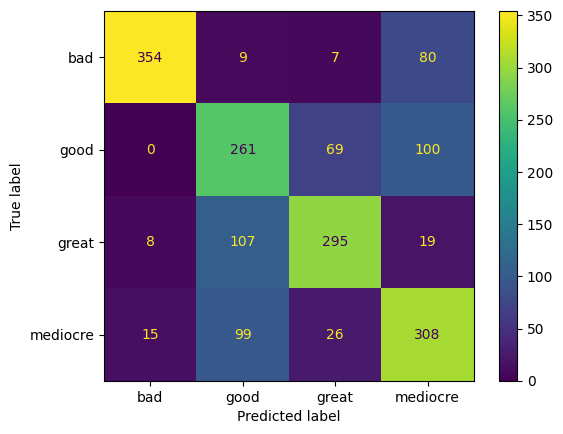

In [70]:
cm = confusion_matrix(Y_test_encoded, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.show()